In [7]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
train = pd.read_csv('./dataset/train.csv')
train.drop(columns='id', inplace=True)

test = pd.read_csv('./dataset/test.csv')
sample_submission = pd.read_csv('./dataset/sample_submission.csv')

In [4]:
train = pd.get_dummies(train, columns=['Species', 'Island'])
train['Clutch Completion'] = train['Clutch Completion'].eq('Yes').mul(1)
train['Sex'] = train['Sex'].eq('MALE').mul(1)

numeric_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']
train[numeric_cols] = np.log1p(train[numeric_cols])
train.fillna(0, inplace=True)

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
scaler = StandardScaler()
train[numeric_cols] = scaler.fit_transform(train[numeric_cols])

In [24]:
train = pd.get_dummies(train, columns=['Species', 'Island', 'Sex'])

In [25]:
train['Clutch Completion'] = train['Clutch Completion'].eq('Yes').mul(1)

In [32]:
train.fillna(0, inplace=True)

In [3]:
test = pd.get_dummies(test, columns=['Species', 'Island'])
test['Clutch Completion'] = test['Clutch Completion'].eq('Yes').mul(1)
test['Sex'] = test['Sex'].eq('MALE').mul(1)

numeric_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']
test[numeric_cols] = np.log1p(test[numeric_cols])
test.fillna(0, inplace=True)

## Ridge

In [5]:
x_train = train.drop(columns=['Body Mass (g)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen'])
y_train = train['Body Mass (g)']

In [6]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

alphas = [0,0.1,1,10,50]

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    neg_mse_scores = cross_val_score(ridge, x_train, y_train, scoring = 'neg_mean_squared_error', cv = 5)
    avg_rmse = np.mean(np.sqrt(-neg_mse_scores))
    print('alpha 값 ', alpha, '일때 평균 rmse :', np.round(avg_rmse,4))    

alpha 값  0 일때 평균 rmse : 318.3601
alpha 값  0.1 일때 평균 rmse : 313.6235
alpha 값  1 일때 평균 rmse : 321.5818
alpha 값  10 일때 평균 rmse : 365.7111
alpha 값  50 일때 평균 rmse : 540.6165


In [13]:
ridge = Ridge(alpha = 10)
ridge.fit(x_train, y_train)

x_test = test.drop(columns=['id', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen'])

sample_submission['Body Mass (g)'] = ridge.predict(x_test)
sample_submission.to_csv('./penguin_result_{}.csv'.format(datetime.now().strftime('%Y%m%d%H%M')), index=False)

## xgb, LGBM

In [20]:
import xgboost as xgb
from lightgbm import LGBMRegressor

In [15]:
from sklearn.model_selection import GridSearchCV

def get_best_params(model, params, cv=5):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=cv)
    grid_model.fit(x_train, y_train)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('최적 평균 RMSE 값:', np.round(rmse, 4))
    print('최적 파라미터:', grid_model.best_params_)
    
    return grid_model.best_estimator_

In [16]:
lgbm_params = {
    'n_estimators':[500, 1000, 1500, 2000], 
    'learning_rate': [0.1, 0.05, 0.01, 0.005], 
    'max_depth': [1,2,3,4]
}

lgbm_reg = LGBMRegressor(max_depth=3, n_estimators=1000)
best_lgbm = get_best_params(lgbm_reg, lgbm_params)

최적 평균 RMSE 값: 318.8624
최적 파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}


<BarContainer object of 10 artists>

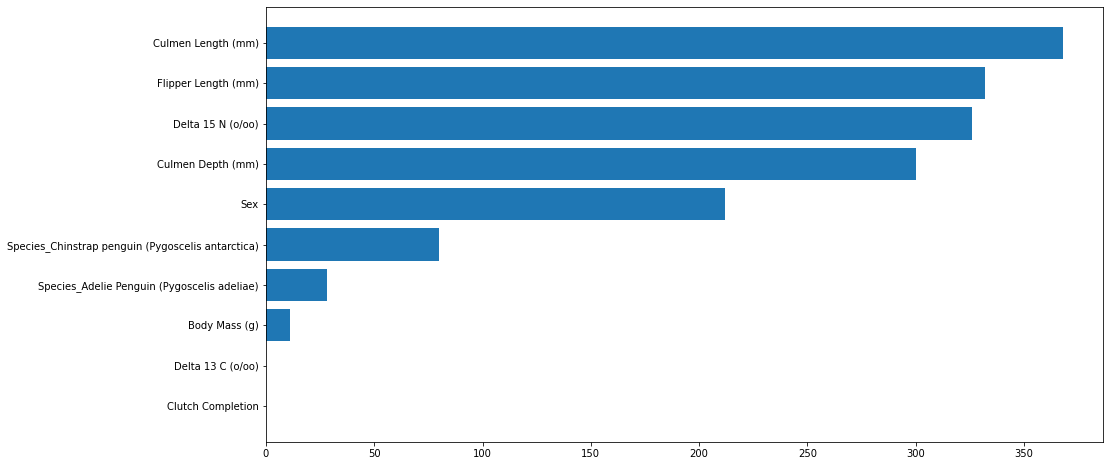

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
sorted_idx = best_lgbm.feature_importances_.argsort()

plt.figure(figsize=(15,8))
plt.barh(train.columns[sorted_idx], best_lgbm.feature_importances_[sorted_idx])

In [19]:
sample_submission['Body Mass (g)'] = best_lgbm.predict(x_test)
sample_submission.to_csv('./penguin_result_{}.csv'.format(datetime.now().strftime('%Y%m%d%H%M')), index=False)

## Regressor

In [31]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from catboost import CatBoostRegressor
from ngboost import NGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [34]:
ngb = NGBRegressor(random_state = 521, verbose = 500, n_estimators = 500)
ngb.fit(x_train, y_train)

[iter 0] loss=8.0761 val_loss=0.0000 scale=1.0000 norm=664.8434
[iter 100] loss=7.2262 val_loss=0.0000 scale=2.0000 norm=426.5614
[iter 200] loss=6.6318 val_loss=0.0000 scale=2.0000 norm=283.7399
[iter 300] loss=6.3120 val_loss=0.0000 scale=2.0000 norm=233.4449
[iter 400] loss=6.1132 val_loss=0.0000 scale=1.0000 norm=101.1570


NGBRegressor(random_state=RandomState(MT19937) at 0x7FDDE949F048, verbose=500)

In [36]:
sample_submission['Body Mass (g)'] = ngb.predict(x_test)
sample_submission.to_csv('./penguin_result_{}.csv'.format(datetime.now().strftime('%Y%m%d%H%M')), index=False)